# 1. Notebook Styling and Library Installation
You can ignore this cell and move to library imports.

In [92]:
#!pip install graphviz
#!pip install pydotplus
#!conda install python-graphviz -y
#!pip install shap

In [93]:
# IPython display functions
import IPython
from IPython.display import display, HTML, SVG, Image

# Decision Tree Visualization
import graphviz
from graphviz import Source
from io import StringIO

# General Plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

# 2. Library Imports

In [94]:
### Library for decision tree visualization
import pydotplus
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn.metrics import * 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
# Feature importance
import shap
import matplotlib.pyplot as plt
# load JS visualization code to notebook
shap.initjs()

In [95]:
# ## 3.1 Confusion Matrix
# Confusion matrices are an important toolkit in every data scientist's box. We have created a function for you that you can use to create visual confusion matrices and analyze your models.
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Leave\nRecall=" + str(recallNegative) , "Stay\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Leave\nPrecision=" + str(precisionNegative) , "Stay\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()

In [96]:
# Print metrics
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    return auc

## 3.3 Feature Importance
Every machine learning model sorts the features based on their importance and use them accordingly. We can take a look at those important features using the following function.

In [97]:
def showFeatureImportance(classifier, columns):
    columns = columns[2:-1]
    
    # Plot size and font size
    plt.rcParams['figure.figsize'] = [16, 6]
    PLOT_FONT_SIZE = 14
    
    # Get feature importance values
    featureImportance = classifier.feature_importances_
    featureImportanceWithColumns = list(reversed(sorted([[featureImportance[i], columns[i]] for i in range(0, len(columns))])))
    sortedColumns = [item[1] for item in featureImportanceWithColumns]
    sortedFeatures = [item[0] for item in featureImportanceWithColumns]
    
    
    # Plotting
    xaxis = np.arange(len(featureImportance))
    plt.bar(xaxis, sortedFeatures, width = 0.5, color = 'white', hatch = '//', edgecolor = '#8a4191', linewidth = 2.0)
    plt.xticks(xaxis, sortedColumns, fontsize = PLOT_FONT_SIZE, rotation = 45)
    plt.yticks(fontsize = PLOT_FONT_SIZE)
    plt.xlabel("Feature Name",fontsize = PLOT_FONT_SIZE)
    plt.ylabel("Feature Importance",fontsize = PLOT_FONT_SIZE)
    plt.title("Feature Importances", fontsize = PLOT_FONT_SIZE)
    plt.show()
    
    # Table
    importanceDataFrame = pd.DataFrame(featureImportanceWithColumns)
    display(importanceDataFrame)


In [98]:
# Read data into a data frame
data = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Train.csv", ","))
# Delete null values
data = data.dropna()
# Get column names. We will use these for visualization purposes
columns = list(data.columns)
# Display the data frame as a table
display(data)

,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment,IntentToStay
0,22684,100234,11,4,1,24,1,6,2,4.5,4.67,4.67,5.0,5.0,4.50,1
1,38792,100100,11,4,1,12,1,5,4,2.0,2.33,4.00,3.5,2.5,4.00,0
2,23552,100246,3,2,3,20,1,8,1,5.0,5.00,5.00,5.0,5.0,5.00,1
3,10801,100209,10,5,1,21,1,8,2,4.5,2.67,2.00,2.5,4.0,2.50,1
4,18343,100099,4,3,2,38,1,8,1,5.0,4.67,4.67,5.0,5.0,5.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,31739,100281,6,3,2,21,1,2,2,3.0,3.00,5.00,3.0,4.0,4.50,0
4796,18126,100078,11,4,1,28,1,5,1,3.0,4.00,3.00,2.0,3.0,4.25,0
4797,28158,100158,3,2,1,7,1,5,1,5.0,5.00,4.33,5.0,5.0,4.75,1
4798,29268,100252,6,3,2,7,1,7,2,4.5,3.67,5.00,4.0,4.5,4.50,1


In [99]:
data.describe( )

,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment,IntentToStay
count,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,20145.133750,100188.640625,6.006667,3.012708,1.878333,17.722708,0.878333,5.901458,2.143750,4.329063,4.089387,4.260598,4.129479,4.264167,4.341927,0.546042
std,11402.822283,64.118803,2.565653,0.674333,0.804621,8.667024,0.326934,1.969151,0.910087,0.800799,0.929284,0.912750,1.010909,0.785633,0.757885,0.497928
min,8.000000,100063.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,10463.500000,100143.000000,4.000000,3.000000,1.000000,12.000000,1.000000,5.000000,2.000000,4.000000,3.670000,4.000000,3.500000,4.000000,4.000000,0.000000
50%,20251.000000,100196.000000,6.000000,3.000000,2.000000,21.000000,1.000000,6.000000,2.000000,4.500000,4.000000,4.670000,4.500000,4.500000,4.500000,1.000000
75%,29866.000000,100242.000000,6.000000,3.000000,3.000000,21.000000,1.000000,8.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000
max,39874.000000,100307.000000,11.000000,5.000000,3.000000,42.000000,1.000000,8.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c24cd1310>,
      dtype=object)

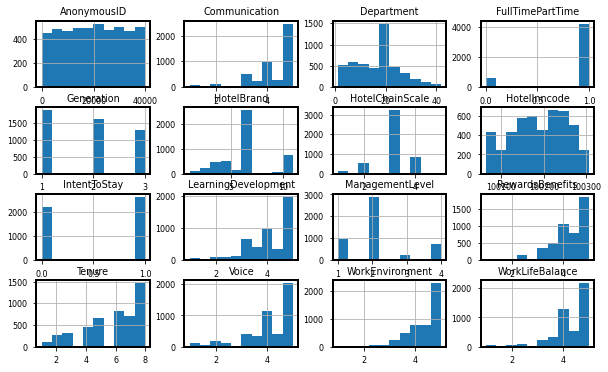

In [100]:
data.hist()

In [101]:
columns=['HotelBrand', 'HotelChainScale',
       'Generation', 'Department', 'FullTimePartTime', 'Tenure',
       'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment',
       'IntentToStay']
df = data[['HotelBrand', 'HotelChainScale',
       'Generation', 'Department', 'FullTimePartTime', 'Tenure',
       'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment',
       'IntentToStay']]
correlations = df.corr()
print (correlations)

                     HotelBrand  HotelChainScale  Generation  Department  \
HotelBrand             1.000000         0.583732   -0.007177    0.095010   
HotelChainScale        0.583732         1.000000   -0.005983    0.046846   
Generation            -0.007177        -0.005983    1.000000    0.016436   
Department             0.095010         0.046846    0.016436    1.000000   
FullTimePartTime      -0.018161         0.030644    0.102935    0.111122   
Tenure                 0.036220         0.075169    0.458656   -0.016143   
ManagementLevel       -0.014778        -0.000261    0.070557   -0.018589   
WorkLifeBalance       -0.042194        -0.036687    0.030617   -0.000211   
LearningDevelopment   -0.015329        -0.024708    0.024636    0.028141   
Communication         -0.017535        -0.046363    0.024645    0.012104   
Voice                 -0.039539        -0.058200    0.033845   -0.001526   
RewardsBenefits       -0.042380        -0.049408   -0.001064    0.004364   
WorkEnvironm

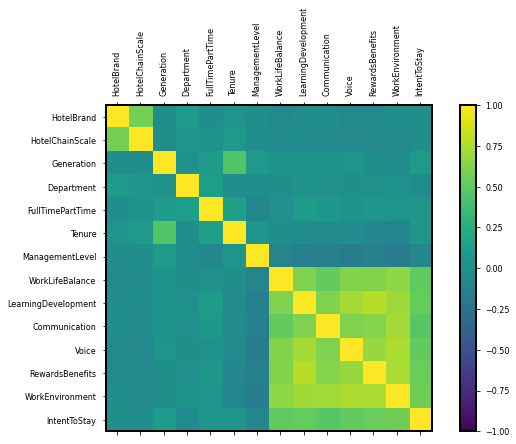

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_color_cycle(['red','black','yellow'])
cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
#cax = ax.imshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(columns, rotation=90)
ax.set_yticklabels(columns)
plt.show()


In [103]:
# dataList

In [104]:
## ## 4.2 Feature and Label Vectors  ##

# Convert data to a list of lists
dataList = data.values.tolist()

# Get features
features = []

# Iterate over each row
for row in dataList:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = row[2:-1]
    
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    features.append(featureValues)
    
# Get labels from the data
labels = [row[-1] for row in dataList]

# Label distribution for Leave and Stay respectively
print("Label distribution of 0 and 1", labels.count(0), labels.count(1))

Label distribution of 0 and 1 2179 2621


In [105]:
## 4.3 Data Splitting

In [106]:
# Test data percentage (0.1 = 10%)
# Note - since the final test set is the blinded Kaggle data, this is essentially a validation set for parameter tuning
TEST_DATA_PERCENTAGE = 0.1

# Split into train and test
trainData, testData, trainLabels, testLabels = train_test_split(features, labels, test_size=TEST_DATA_PERCENTAGE)

In [107]:
# 5. Machine Learning
## 5.1 Decision Trees

In [108]:
set_background('#ffefb7')
# Things you can change                                                                                          
MAXIMUM_TREE_DEPTH = 3 # Maximum depth of the decision tree that we are going to train                                                           #
#####################################################################################################################################################

In [109]:
# Create an instance of the decision tree algorithm. You can consider "classifier" as a function that is going to get training data and train a decision tree algorithm. Next, it will take any test data and make a prediction based on the learned decision tree
classifierDt = DecisionTreeClassifier(max_depth = MAXIMUM_TREE_DEPTH, random_state = 1)

# Train the decision tree model using the function .fit
classifierDt.fit(trainData, trainLabels)

# Calculate training accuracy of the classifier
trainAccuracy = classifierDt.score(trainData, trainLabels)

# Predict on test data
predictions = classifierDt.predict(testData) # This will give binary labels e.g 0/1
predictionProbabilities = classifierDt.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.

Accuracy: 79.38
PrecisionNegative: 76.21
PrecisionPositive: 82.76
RecallNegative: 82.53
RecallPositive: 76.49
AUC Score: 86.94



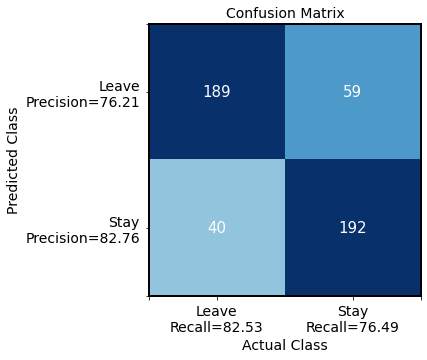

In [110]:
# Calculate metrics on test set and display them
dtAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels) # just return the AUC because we will use it later on in ROC Section

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateDt, truePositiveRateDt, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

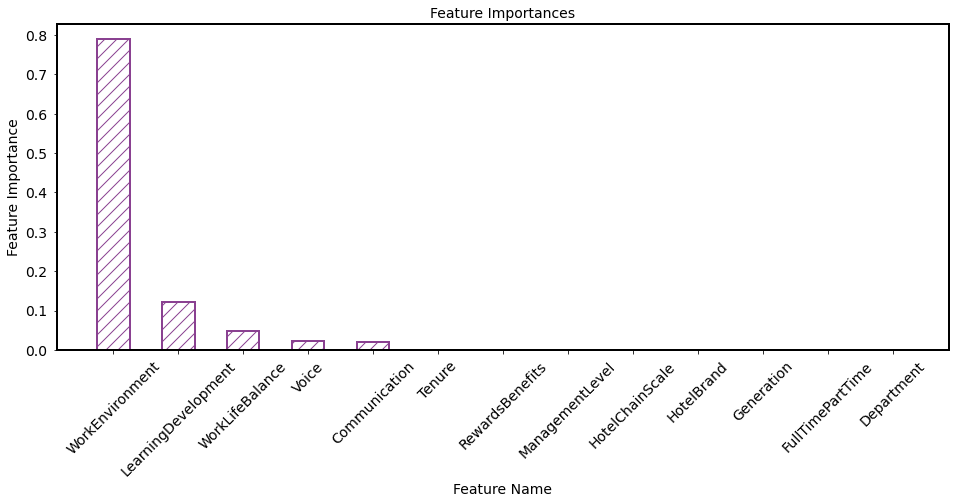

,0,1
0,0.788609,WorkEnvironment
1,0.120913,LearningDevelopment
2,0.048240,WorkLifeBalance
3,0.023006,Voice
4,0.019232,Communication
5,0.000000,Tenure
6,0.000000,RewardsBenefits
7,0.000000,ManagementLevel
8,0.000000,HotelChainScale
9,0.000000,HotelBrand


In [111]:
# Calculate feature importance
columns = list(data.columns)
showFeatureImportance(classifierDt, columns)

In [112]:
### 5.1.1 Decision Tree Visualization

dot_data = StringIO()
tree.export_graphviz(classifierDt, out_file=dot_data, 
                                    feature_names=columns[2:-1],
                                    filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))

## 5.2 Grid Search
Grid search lets us try out every possible combination of the parameters available to us. For instance, for decision tree, we can change the add multiple values of maximum depth in a list and give that list to a Grid Search function which will apply every depth and save the best performing model with the optimal depth value.
<img src="https://i.stack.imgur.com/cIDuR.png">

Read more: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [121]:
from sklearn.model_selection import GridSearchCV

In [122]:
set_background('#ffefb7')
#####################################################################################################################################################
# Things you can change                                                                                                                             #
#####################################################################################################################################################
# GridSearchCV function takes in a parameter dictionary which is very important here. 
# The dictionary contains as keys the parameter names and values are the possible values of the parameter that you want to test
parameters = {'max_depth': [2, 4, 6]} # You can add different depths here.
#####################################################################################################################################################

In [123]:
###### We will repeat the same process we did in the previous DecisionTreeClassifier cell but we'll now wrap our classifier inside the GridSearch function.
# Create an instance of the decision tree algorithm. You can consider "classifier" as a function that is going to get training data and train a decision tree algorithm. Next, it will take any test data and make a prediction based on the learned decision tree
classifierDtGrid = GridSearchCV(DecisionTreeClassifier(), parameters)

# Train the decision tree model using the function .fit
classifierDtGrid.fit(trainData, trainLabels)

# Calculate training accuracy of the classifier
trainAccuracy = classifierDtGrid.score(trainData, trainLabels)

# Predict on test data
predictions = classifierDtGrid.predict(testData) # This will give binary labels e.g 0/1
predictionProbabilities = classifierDtGrid.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.

Accuracy: 80.00
PrecisionNegative: 76.92
PrecisionPositive: 83.26
RecallNegative: 82.97
RecallPositive: 77.29
AUC Score: 86.74



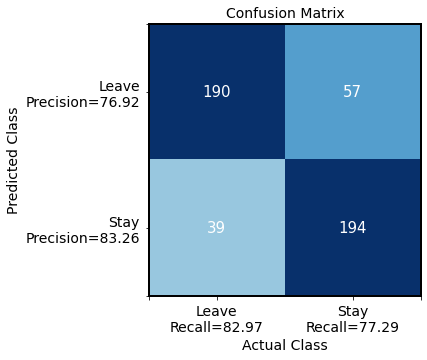

Best Parameters are:  {'max_depth': 4}


In [124]:
# Calculate metrics on test set and display them
dtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateDtWithGridSearch, truePositiveRateDtWithGridSearch, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.
print("Best Parameters are: ", classifierDtGrid.best_params_)

# 5.3 Advanced Stuff: XgBoost
XgBoost (Gradient Boosted Trees) is the most widely used machine learning algorithm in the industry these days. It is a powerful algorithm that mixes decision trees, random forests, boosting, and gradients to come up effective classifiers for our data sets. Plenty of kaggle competitions have been won by using this algorithm.

<img src="https://miro.medium.com/max/1042/1*6dGA56_UXJzuDAlAOd9Otw.png">

Good explanation of XgBoost: 
https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/boosting?ex=5
https://www.youtube.com/watch?v=YABWwCLPfZs

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

In [130]:
# Create an instance of the decision tree algorithm. You can consider "classifier" as a function that is going to get training data and train a decision tree algorithm. Next, it will take any test data and make a prediction based on the learned decision tree
gbClassifier = GradientBoostingClassifier(random_state = 1)

# Train the decision tree model using the function .fit
gbClassifier.fit(trainData, trainLabels)

# Calculate training accuracy of the classifier
trainAccuracy = gbClassifier.score(trainData, trainLabels)

# Predict on test data
predictions = gbClassifier.predict(testData) # This will give binary labels e.g 0/1
predictionProbabilities = gbClassifier.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.

Accuracy: 80.00
PrecisionNegative: 78.79
PrecisionPositive: 81.12
RecallNegative: 79.48
RecallPositive: 80.48
AUC Score: 89.07



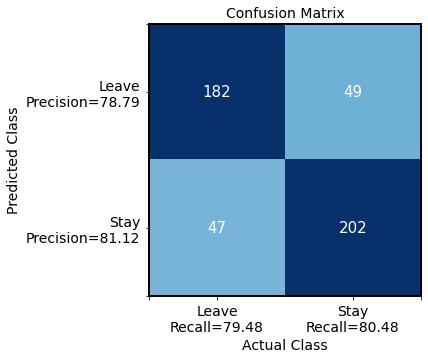

In [131]:
# Calculate metrics on test set and display them
gbtAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateGb, truePositiveRateGb, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

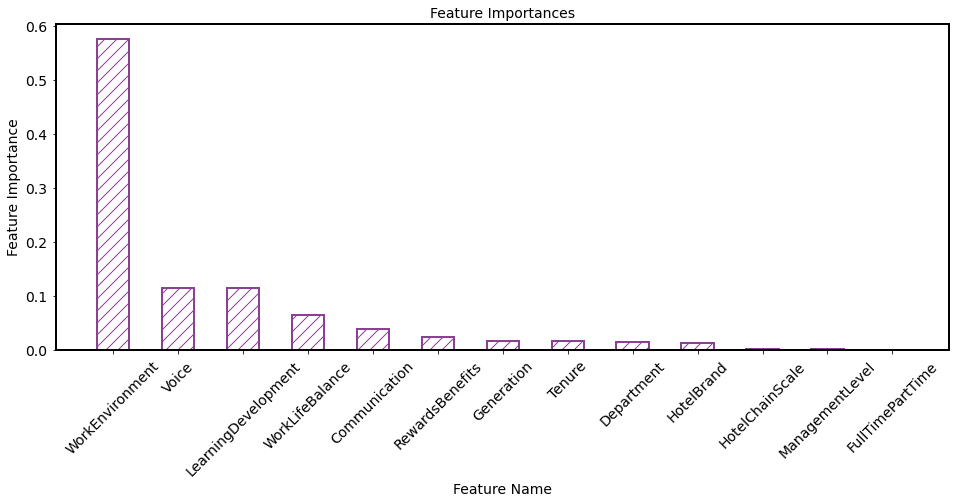

,0,1
0,0.575151,WorkEnvironment
1,0.115112,Voice
2,0.113993,LearningDevelopment
3,0.064846,WorkLifeBalance
4,0.038191,Communication
5,0.024618,RewardsBenefits
6,0.017188,Generation
7,0.016975,Tenure
8,0.015721,Department
9,0.013773,HotelBrand


In [132]:
# Calculate feature importance
showFeatureImportance(gbClassifier, columns)

## 5.3.1 Grid Search on XgBoost
XgBoost has so many parameters that you can tune. Let us try to do a grid search on those parameters to get the best model possible. The list of all parameters is listed here:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

set_background('#ffffff')
#####################################################################################################################################################
# Things you can change                                                                                                                             #
#####################################################################################################################################################
# GridSearchCV function takes in a parameter dictionary which is very important here. 
# The dictionary contains as keys the parameter names and values are the possible values of the parameter that you want to test
parameters = {'max_depth': [6, 10],
              'learning_rate': [0.1,0.2],
             'n_estimators': [20, 100],
             'subsample': [1.0]} # You can add different depths here.

# In order to learn about these parameters and their possible values, please go to:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_
#####################################################################################################################################################

In [142]:
set_background('#ffffff')
#####################################################################################################################################################
# Things you can change                                                                                                                             #
#####################################################################################################################################################
# GridSearchCV function takes in a parameter dictionary which is very important here. 
# The dictionary contains as keys the parameter names and values are the possible values of the parameter that you want to test
parameters = {'max_depth': [6, 10],
              'learning_rate': [0.1,0.2],
             'n_estimators': [20, 100],
             'subsample': [1.0]} # You can add different depths here.

# In order to learn about these parameters and their possible values, please go to:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_
#####################################################################################################################################################

In [143]:
###### We will repeat the same process we did in the previous DecisionTreeClassifier cell but we'll now wrap our classifier inside the GridSearch function.
# Create an instance of the decision tree algorithm. You can consider "classifier" as a function that is going to get training data and train a decision tree algorithm. Next, it will take any test data and make a prediction based on the learned decision tree
gbClassifierWithGridSearch = GridSearchCV(GradientBoostingClassifier(), parameters)

# Train the decision tree model using the function .fit
gbClassifierWithGridSearch.fit(trainData, trainLabels)

# Calculate training accuracy of the classifier
trainAccuracy = gbClassifierWithGridSearch.score(trainData, trainLabels)

# Predict on test data
predictions = gbClassifierWithGridSearch.predict(testData) # This will give binary labels e.g 0/1
predictionProbabilities = gbClassifierWithGridSearch.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.

Accuracy: 80.00
PrecisionNegative: 79.56
PrecisionPositive: 80.39
RecallNegative: 78.17
RecallPositive: 81.67
AUC Score: 88.39



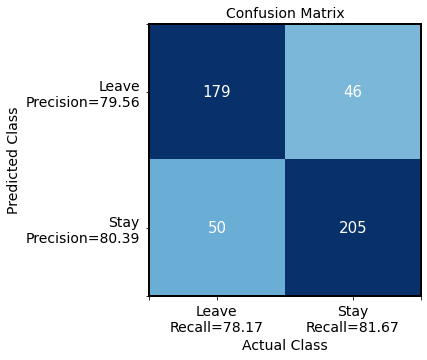

Best Parameters are:  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 20, 'subsample': 1.0}


In [144]:
# Calculate metrics on test set and display them
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.
print("Best Parameters are: ", gbClassifierWithGridSearch.best_params_)

print("AUC values for different classifiers...")
print("AUC value for Decision Tree: %.3f\nDecision Tree with Grid Search: %.3f\nGradient Boosted Trees: %.3f\nGradient Boosted Trees with Grid Search: %.3f" % (dtAUC, dtGridAUC, gbtAUC, gbtGridAUC))

In [145]:
print("AUC values for different classifiers...")
print("AUC value for Decision Tree: %.3f\nDecision Tree with Grid Search: %.3f\nGradient Boosted Trees: %.3f\nGradient Boosted Trees with Grid Search: %.3f" % (dtAUC, dtGridAUC, gbtAUC, gbtGridAUC))

AUC values for different classifiers...
AUC value for Decision Tree: 86.940
Decision Tree with Grid Search: 86.740
Gradient Boosted Trees: 89.070
Gradient Boosted Trees with Grid Search: 88.390


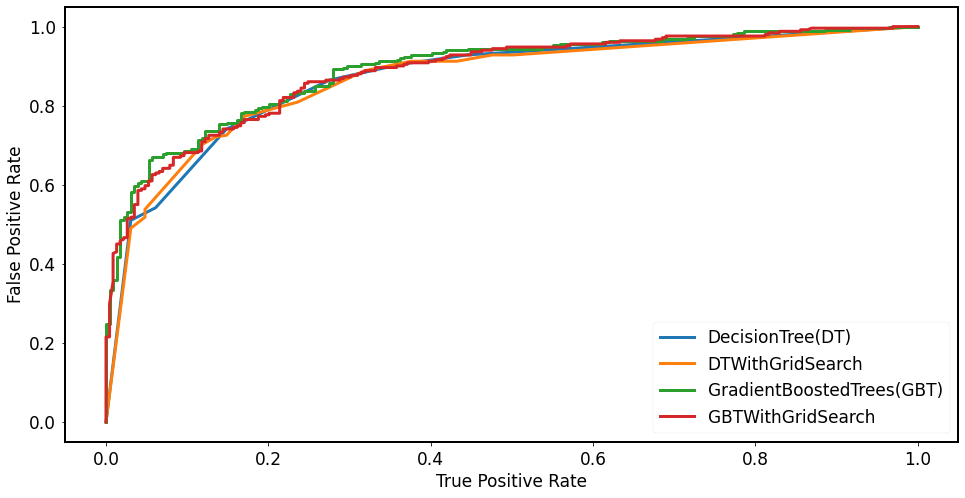

In [146]:
plt.rcParams['figure.figsize'] = [16, 8]
FONT_SIZE = 17

plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 3, label = "DecisionTree(DT)")
plt.plot(falsePositiveRateDtWithGridSearch, truePositiveRateDtWithGridSearch, linewidth = 3, label = "DTWithGridSearch")
plt.plot(falsePositiveRateGb, truePositiveRateGb, linewidth = 3, label = "GradientBoostedTrees(GBT)")
plt.plot(falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, linewidth = 3, label = "GBTWithGridSearch")

plt.legend(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.xlabel("True Positive Rate", fontsize=FONT_SIZE)
plt.ylabel("False Positive Rate", fontsize=FONT_SIZE)
plt.show()

In [147]:
### 5.5.1 Manual Grid Search

In [148]:
depths = [2, 5, 7]
estimators = [10, 20]
learningRate = [0.1, 0.2]

In [149]:
depths = [2, 5, 7]
estimators = [10, 20]
learningRate = [0.1, 0.2]

In [150]:
fprs, tprs, aucs = [], [], [] # false and true positive rates
settingNames = []
bestIndex, bestAUC = -1, -1

settingsPassed = 0
for d in depths:
    for e in estimators:
        for l in learningRate:
            # Create an instance of the decision tree algorithm. You can consider "classifier" as a function that is going to get training data and train a decision tree algorithm. Next, it will take any test data and make a prediction based on the learned decision tree
            gbClassifierCustomGridSearch = GradientBoostingClassifier(max_depth = d, learning_rate = l, n_estimators = e, random_state = 1)

            # Train the decision tree model using the function .fit
            gbClassifierCustomGridSearch.fit(trainData, trainLabels)

            # Predict on test data
            predictions = gbClassifierCustomGridSearch.predict(testData) # This will give binary labels e.g 0/1
            predictionProbabilities = gbClassifierCustomGridSearch.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.
            falsePositiveRate, truePositiveRate, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
            testAUC = roc_auc_score(testLabels, [item[1] for item in predictionProbabilities]) * 100
            
            fprs.append(falsePositiveRate)
            tprs.append(truePositiveRate)
            aucs.append(testAUC)
            settingNames.append("Depth=" + str(d) + "-Estimators=" + str(e)+ "-" + "Lrate="  + str(l))
            
            # Store best index. We will highlight the best AUC setting in the ROC variance curve below
            if testAUC > bestAUC:
                bestAUC = testAUC
                bestIndex = settingsPassed
            
            settingsPassed = settingsPassed + 1
            
print("Best setting is = %s and gives AUC = %.2f\n" % (settingNames[bestIndex], bestAUC))
print("AUC Scores for all settings...")
for i in range(0, len(aucs)):
    print(settingNames[i], aucs[i])

Best setting is = Depth=2-Estimators=20-Lrate=0.2 and gives AUC = 89.28

AUC Scores for all settings...
Depth=2-Estimators=10-Lrate=0.1 88.01823274587241
Depth=2-Estimators=10-Lrate=0.2 88.9681448876981
Depth=2-Estimators=20-Lrate=0.1 88.77329111501594
Depth=2-Estimators=20-Lrate=0.2 89.28130273665165
Depth=5-Estimators=10-Lrate=0.1 88.7741609979297
Depth=5-Estimators=10-Lrate=0.2 88.77068146627464
Depth=5-Estimators=20-Lrate=0.1 88.84114198228919
Depth=5-Estimators=20-Lrate=0.2 88.59670488352268
Depth=7-Estimators=10-Lrate=0.1 88.01388333130362
Depth=7-Estimators=10-Lrate=0.2 87.2214199968684
Depth=7-Estimators=20-Lrate=0.1 88.15393448041894
Depth=7-Estimators=20-Lrate=0.2 87.18923432905932


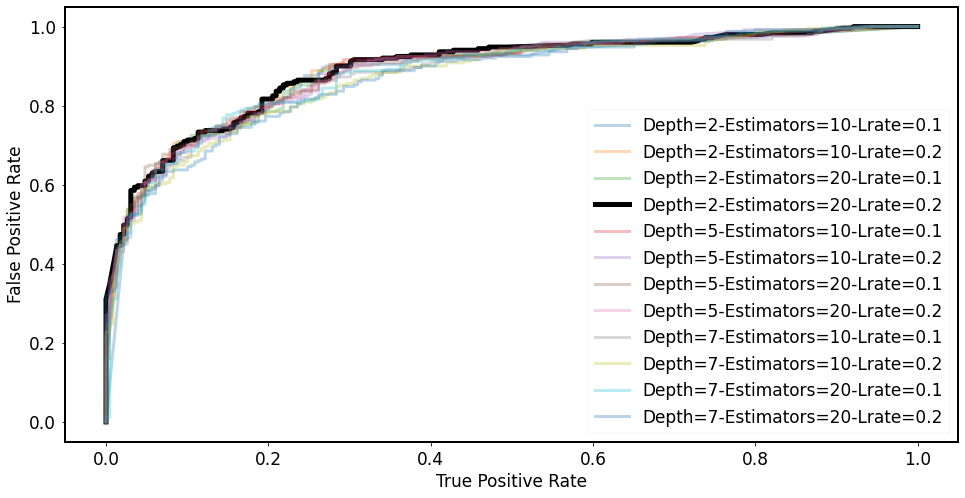

In [151]:
# ROC Variance Curve

plt.rcParams['figure.figsize'] = [16, 8]
FONT_SIZE = 17

for i in range(0, len(settingNames)):
    if i == bestIndex:
        # Best setting
        plt.plot(fprs[i], tprs[i], linewidth = 5, color='black', label = str(settingNames[i]))
    else:
        plt.plot(fprs[i], tprs[i], linewidth = 3, label = str(settingNames[i]), alpha = 0.3)

plt.legend(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.xlabel("True Positive Rate", fontsize=FONT_SIZE)
plt.ylabel("False Positive Rate", fontsize=FONT_SIZE)
plt.show()

# Read data into a data frame
testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))

# Delete null values
testDataForSubmission = testDataForSubmission.dropna()

# Convert data to a list of lists
testDataListForSubmission = testDataForSubmission.values.tolist()

# Get features
testFeaturesForSubmission = []

# Iterate over each row
for row in testDataListForSubmission:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = row[2:]
    
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    testFeaturesForSubmission.append(featureValues)

In [152]:
# Read data into a data frame
testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))

# Delete null values
testDataForSubmission = testDataForSubmission.dropna()

# Convert data to a list of lists
testDataListForSubmission = testDataForSubmission.values.tolist()

# Get features
testFeaturesForSubmission = []

# Iterate over each row
for row in testDataListForSubmission:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = row[2:]
    
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    testFeaturesForSubmission.append(featureValues)

In [153]:
resultsFile = open("Results/dtPredictions.csv", "w")
resultsFile.write("Id,Prediction\n")
for predictionProb, i in zip(classifierDt.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

resultsFile = open("Results/dtPredictionsGrid.csv", "w")
resultsFile.write("Id,Prediction\n")
for predictionProb, i in zip(classifierDtGrid.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

resultsFile = open("Results/gbPredictions.csv", "w")
resultsFile.write("Id,Prediction\n")
for predictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

resultsFile = open("Results/gbPredictionsGrid.csv", "w")
resultsFile.write("Id,Prediction\n")
for predictionProb, i in zip(gbClassifierWithGridSearch.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()
    
print("All predictions have been placed in the results folder...")

All predictions have been placed in the results folder...


## 6.1 Top N Accuracy

def calculateClasswiseTopNAccuracy(model, TOP_N):
    """
    model is a trained model file such as gbClassifier, classifierDt
    TOP_N is the top n% predictions you want to use for each class
    """
    global testData
    predictionProbsTopN = model.predict_proba(testData)
    predictionsTopN = gbClassifier.predict(testData)
    predictionProbsTopNLeave, predictionProbsTopNStay = [item[0] for item in predictionProbsTopN], [item[1] for item in predictionProbsTopN]
    predictionProbsTopNLeave = list(reversed(sorted(predictionProbsTopNLeave)))[:int(len(predictionProbsTopNLeave) * TOP_N / 100)][-1]
    predictionProbsTopNStay = list(reversed(sorted(predictionProbsTopNStay)))[:int(len(predictionProbsTopNStay) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyLeave = []
    accuracyStay = []
    for i in range(0, len(predictionsTopN)):
        if predictionsTopN[i] == 1:
            # Staying
            if predictionProbsTopN[i][1] > predictionProbsTopNStay:
                accuracyStay.append(int(testLabels[i]) == 1)
        else:
            # Leave
            if predictionProbsTopN[i][0] > predictionProbsTopNLeave:
                accuracyLeave.append(int(testLabels[i]) == 0)

    accuracyStay = round((accuracyStay.count(True) * 100) / len(accuracyStay), 2)
    accuracyLeave = round((accuracyLeave.count(True) * 100) / len(accuracyLeave), 2)
    return accuracyLeave, accuracyStay

In [154]:
def calculateClasswiseTopNAccuracy(model, TOP_N):
    """
    model is a trained model file such as gbClassifier, classifierDt
    TOP_N is the top n% predictions you want to use for each class
    """
    global testData
    predictionProbsTopN = model.predict_proba(testData)
    predictionsTopN = gbClassifier.predict(testData)
    predictionProbsTopNLeave, predictionProbsTopNStay = [item[0] for item in predictionProbsTopN], [item[1] for item in predictionProbsTopN]
    predictionProbsTopNLeave = list(reversed(sorted(predictionProbsTopNLeave)))[:int(len(predictionProbsTopNLeave) * TOP_N / 100)][-1]
    predictionProbsTopNStay = list(reversed(sorted(predictionProbsTopNStay)))[:int(len(predictionProbsTopNStay) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyLeave = []
    accuracyStay = []
    for i in range(0, len(predictionsTopN)):
        if predictionsTopN[i] == 1:
            # Staying
            if predictionProbsTopN[i][1] > predictionProbsTopNStay:
                accuracyStay.append(int(testLabels[i]) == 1)
        else:
            # Leave
            if predictionProbsTopN[i][0] > predictionProbsTopNLeave:
                accuracyLeave.append(int(testLabels[i]) == 0)

    accuracyStay = round((accuracyStay.count(True) * 100) / len(accuracyStay), 2)
    accuracyLeave = round((accuracyLeave.count(True) * 100) / len(accuracyLeave), 2)
    return accuracyLeave, accuracyStay

Accuracy for top 50 percent predictions for leave: 78.79, stay: 82.43
Accuracy for top 40 percent predictions for leave: 85.86, stay: 89.53
Accuracy for top 30 percent predictions for leave: 89.51, stay: 95.10
Accuracy for top 20 percent predictions for leave: 90.53, stay: 96.84
Accuracy for top 10 percent predictions for leave: 93.62, stay: 100.00


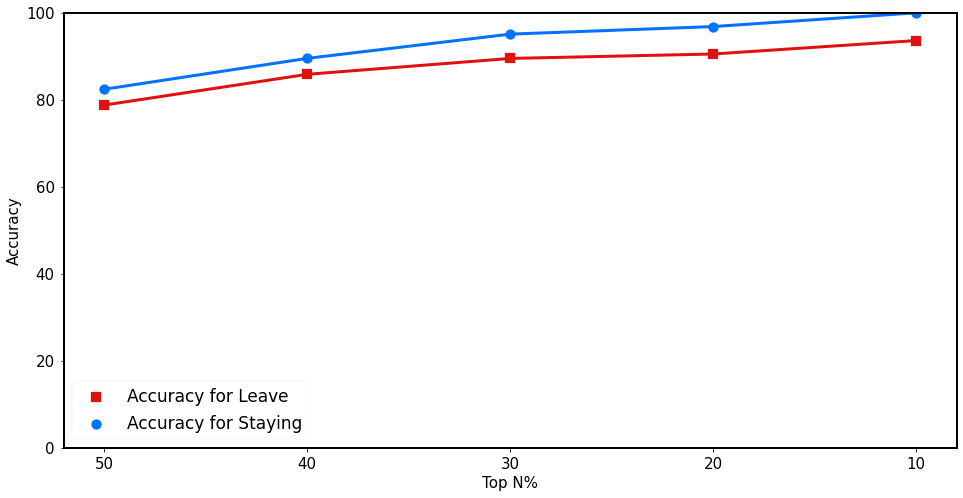

In [155]:
######################################################### You can change values in the list below ################################################
TOP_N_LIST = [50, 40, 30, 20, 10]
####################################################################################################################################################

accuraciesLeave, accuraciesStay = [], []
for n in TOP_N_LIST:
    accuracyLeave, accuracyStay = calculateClasswiseTopNAccuracy(gbClassifier, n)
    accuraciesLeave.append(accuracyLeave)
    accuraciesStay.append(accuracyStay)
    
    print("Accuracy for top %d percent predictions for leave: %.2f, stay: %.2f" % (n, accuracyLeave, accuracyStay))
    
# Plot results
x = np.arange(len(accuraciesLeave))
plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, TOP_N_LIST, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterLeave, scatterStay], ["Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
plt.ylim(0, 100)
plt.show()



In [156]:
data.columns

Index(['AnonymousID', 'HotelInncode', 'HotelBrand', 'HotelChainScale',
       'Generation', 'Department', 'FullTimePartTime', 'Tenure',
       'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment',
       'IntentToStay'],
      dtype='object')

Feature Value = 0.0, Number of instances in data: 54
Accuracy: 85.19
PrecisionNegative: 82.86
PrecisionPositive: 89.47
RecallNegative: 93.55
RecallPositive: 73.91
AUC Score: 93.69



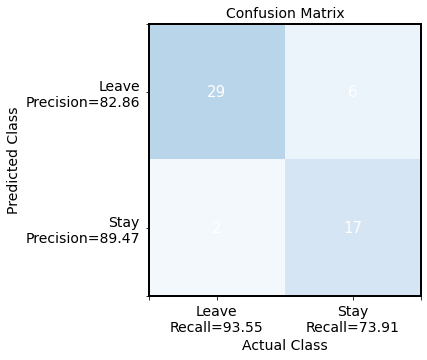

Feature Value = 1.0, Number of instances in data: 426
Accuracy: 79.34
PrecisionNegative: 78.06
PrecisionPositive: 80.43
RecallNegative: 77.27
RecallPositive: 81.14
AUC Score: 88.50



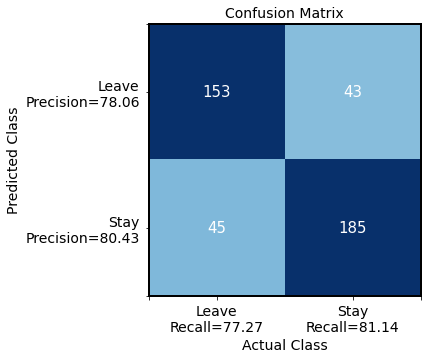

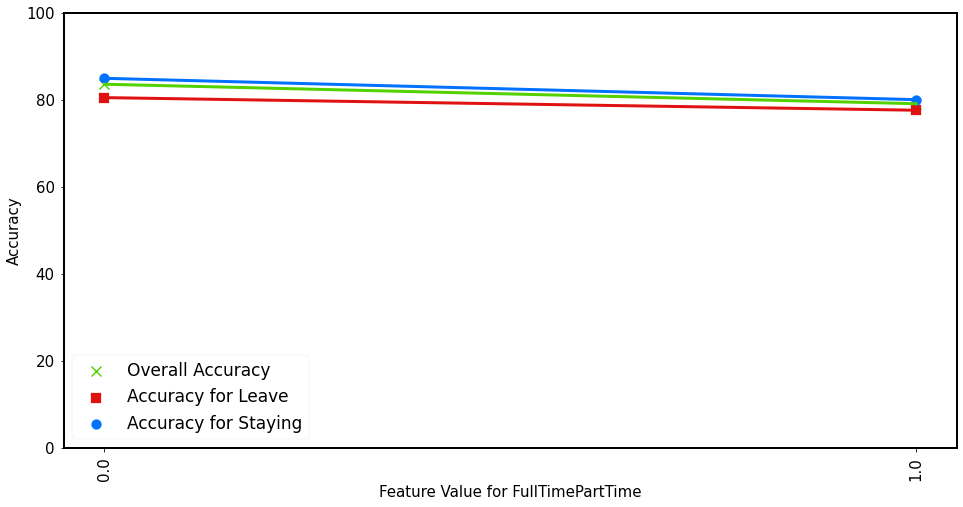

In [157]:
import collections
plt.rcParams['figure.figsize'] = [24, 8] ## plot size

def getFeatureWiseAccuracy(model, featureName):
    testPredictionsForFeatureSegmentation = model.predict(testData)
    testPredictionProbsForFeatureSegmentation = model.predict_proba(testData)
    testDataDataFrame = pd.DataFrame(testData)
    testDataDataFrame.columns = columns[2: -1]

    featureValues = list(testDataDataFrame[featureName])
    uniqueValues = list(sorted(set(featureValues)))
    accuracyPerValue = collections.defaultdict(list)
    accuracyPerValueLeave = collections.defaultdict(list)
    accuracyPerValueStay = collections.defaultdict(list)
    for i in range(0, len(testLabels)):
        accuracyPerValue[featureValues[i]].append([int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]),
                                                    testLabels[i], testPredictionsForFeatureSegmentation[i], testPredictionProbsForFeatureSegmentation[i]])
        if testPredictionsForFeatureSegmentation[i] == 1:
            accuracyPerValueStay[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))
        else:
            accuracyPerValueLeave[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))

    accuracies, accuraciesStay, accuraciesLeave = [], [], []
    for value in uniqueValues:
        accuracyPerValueCounts = [item[0] for item in accuracyPerValue[value]]
        accuracy = round((accuracyPerValueCounts.count(True) * 100) / (len(accuracyPerValueCounts) + 1), 2) # 1 is added in the denominator for division by zero errors. Please leave it there.
        accuracyStay = round((accuracyPerValueStay[value].count(True) * 100) / (len(accuracyPerValueStay[value]) + 1), 2)
        accuracyLeave = round((accuracyPerValueLeave[value].count(True) * 100) / (len(accuracyPerValueLeave[value]) + 1), 2)
        #    print("Feature Value = %.1f, Overall Accuracy: %.2f, Accuracy for Staying: %.2f, Accuracy for Leaving: %.2f" % (value, accuracy, accuracyStay, accuracyLeave))
        print("Feature Value = %.1f, Number of instances in data: %d" % (value, len(accuracyPerValueCounts)))
    
        # Confusion matrices
        _predictions = [item[2] for item in accuracyPerValue[value]]
        _predictionsProbs = [item[3] for item in accuracyPerValue[value]]
        _testLabels = [item[1] for item in accuracyPerValue[value]]
        _ = calculateMetricsAndPrint(_predictions, _predictionsProbs, _testLabels)
        
        # Add to lists for plotting
        accuracies.append(accuracy), accuraciesStay.append(accuracyStay), accuraciesLeave.append(accuracyLeave)
    
    # Plotting
    plt.rcParams['figure.figsize'] = [16, 8]
    x = np.arange(len(accuracies))
    plt.plot(x, accuracies, linewidth = 3, color = '#53d100')
    scatterAcc = plt.scatter(x, accuracies, marker = 'x', s = 100, color = '#53d100')
    plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
    scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
    plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
    scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
    plt.xticks(x, uniqueValues, fontsize = 15, rotation = 90)
    plt.yticks(fontsize = 15)
    plt.xlabel("Feature Value for " + featureName, fontsize = 15)
    plt.ylabel("Accuracy", fontsize = 15)
    plt.legend([scatterAcc, scatterLeave, scatterStay], ["Overall Accuracy", "Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
    plt.ylim(0, 100)
    plt.show()
    
############################################## Add your feature name here ###################################
FEATURE_NAME = "FullTimePartTime" # This has to be a valid feature name
#############################################################################################################
getFeatureWiseAccuracy(gbClassifier, FEATURE_NAME)

#If you want to segment every feature and get results, you can loop over the feature names as given in the next two lines.
#for col in columns[2:-1]:
#    getFeatureWiseAccuracy(gbClassifier, col)

Feature Value = 0.0, Number of instances in data: 54
Accuracy: 85.19
PrecisionNegative: 82.86
PrecisionPositive: 89.47
RecallNegative: 93.55
RecallPositive: 73.91
AUC Score: 93.69



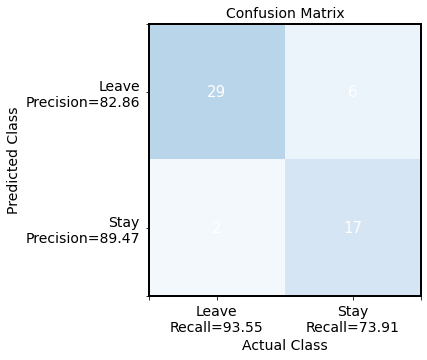

Feature Value = 1.0, Number of instances in data: 426
Accuracy: 79.34
PrecisionNegative: 78.06
PrecisionPositive: 80.43
RecallNegative: 77.27
RecallPositive: 81.14
AUC Score: 88.50



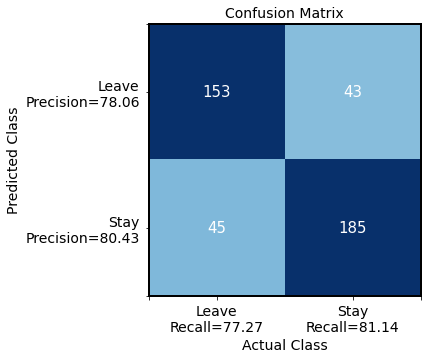

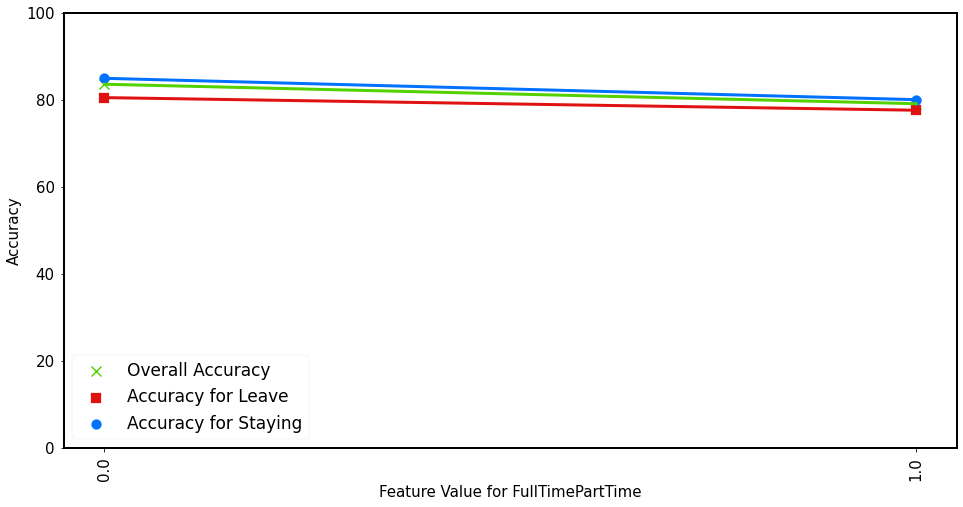

In [158]:
import collections
plt.rcParams['figure.figsize'] = [24, 8] ## plot size

def getFeatureWiseAccuracy(model, featureName):
    testPredictionsForFeatureSegmentation = model.predict(testData)
    testPredictionProbsForFeatureSegmentation = model.predict_proba(testData)
    testDataDataFrame = pd.DataFrame(testData)
    testDataDataFrame.columns = columns[2: -1]

    featureValues = list(testDataDataFrame[featureName])
    uniqueValues = list(sorted(set(featureValues)))
    accuracyPerValue = collections.defaultdict(list)
    accuracyPerValueLeave = collections.defaultdict(list)
    accuracyPerValueStay = collections.defaultdict(list)
    for i in range(0, len(testLabels)):
        accuracyPerValue[featureValues[i]].append([int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]),
                                                    testLabels[i], testPredictionsForFeatureSegmentation[i], testPredictionProbsForFeatureSegmentation[i]])
        if testPredictionsForFeatureSegmentation[i] == 1:
            accuracyPerValueStay[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))
        else:
            accuracyPerValueLeave[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))

    accuracies, accuraciesStay, accuraciesLeave = [], [], []
    for value in uniqueValues:
        accuracyPerValueCounts = [item[0] for item in accuracyPerValue[value]]
        accuracy = round((accuracyPerValueCounts.count(True) * 100) / (len(accuracyPerValueCounts) + 1), 2) # 1 is added in the denominator for division by zero errors. Please leave it there.
        accuracyStay = round((accuracyPerValueStay[value].count(True) * 100) / (len(accuracyPerValueStay[value]) + 1), 2)
        accuracyLeave = round((accuracyPerValueLeave[value].count(True) * 100) / (len(accuracyPerValueLeave[value]) + 1), 2)
        #    print("Feature Value = %.1f, Overall Accuracy: %.2f, Accuracy for Staying: %.2f, Accuracy for Leaving: %.2f" % (value, accuracy, accuracyStay, accuracyLeave))
        print("Feature Value = %.1f, Number of instances in data: %d" % (value, len(accuracyPerValueCounts)))
    
        # Confusion matrices
        _predictions = [item[2] for item in accuracyPerValue[value]]
        _predictionsProbs = [item[3] for item in accuracyPerValue[value]]
        _testLabels = [item[1] for item in accuracyPerValue[value]]
        _ = calculateMetricsAndPrint(_predictions, _predictionsProbs, _testLabels)
        
        # Add to lists for plotting
        accuracies.append(accuracy), accuraciesStay.append(accuracyStay), accuraciesLeave.append(accuracyLeave)
    
    # Plotting
    plt.rcParams['figure.figsize'] = [16, 8]
    x = np.arange(len(accuracies))
    plt.plot(x, accuracies, linewidth = 3, color = '#53d100')
    scatterAcc = plt.scatter(x, accuracies, marker = 'x', s = 100, color = '#53d100')
    plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
    scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
    plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
    scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
    plt.xticks(x, uniqueValues, fontsize = 15, rotation = 90)
    plt.yticks(fontsize = 15)
    plt.xlabel("Feature Value for " + featureName, fontsize = 15)
    plt.ylabel("Accuracy", fontsize = 15)
    plt.legend([scatterAcc, scatterLeave, scatterStay], ["Overall Accuracy", "Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
    plt.ylim(0, 100)
    plt.show()
    
############################################## Add your feature name here ###################################
FEATURE_NAME = "FullTimePartTime" # This has to be a valid feature name
#############################################################################################################
getFeatureWiseAccuracy(gbClassifier, FEATURE_NAME)

#If you want to segment every feature and get results, you can loop over the feature names as given in the next two lines.
#for col in columns[2:-1]:
#    getFeatureWiseAccuracy(gbClassifier, col)

In [159]:
############################################
# modelToExplain is the model you want to use for explanation
modelToExplain = classifierDt ######### PLEASE DO NOT CHANGE THIS. SHAP PACKAGE CURRENTLY WORKS WITH DECISION TREES ONLY.
############################################
#####################################
# Index is the row number which you want to explain
index = 100
#####################################

explainer = shap.TreeExplainer(modelToExplain)
shapValues = np.array(explainer.shap_values(np.array(trainData)))

# Convert to dataframe, that's what shapley package uses
trainDataDf = pd.DataFrame(trainData)
trainDataDf.columns = columns[2:-1]

print("Creating the plot for explaining the instance for 'STAY'...")
print("The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.")
shap.force_plot(explainer.expected_value[1], shapValues[1][index,:], trainDataDf.iloc[index,:])

Creating the plot for explaining the instance for 'STAY'...
The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.


In [160]:
############################################
# modelToExplain is the model you want to use for explanation
modelToExplain = classifierDt ######### PLEASE DO NOT CHANGE THIS. SHAP PACKAGE CURRENTLY WORKS WITH DECISION TREES ONLY.
############################################
#####################################
# Index is the row number which you want to explain
index = 100
#####################################

explainer = shap.TreeExplainer(modelToExplain)
shapValues = np.array(explainer.shap_values(np.array(trainData)))

# Convert to dataframe, that's what shapley package uses
trainDataDf = pd.DataFrame(trainData)
trainDataDf.columns = columns[2:-1]

print("Creating the plot for explaining the instance for 'STAY'...")
print("The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.")
shap.force_plot(explainer.expected_value[1], shapValues[1][index,:], trainDataDf.iloc[index,:])

Creating the plot for explaining the instance for 'STAY'...
The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.


shap.summary_plot(shapValues[1], trainDataDf)

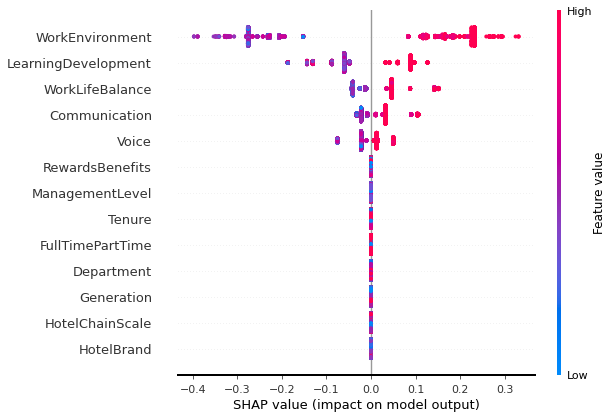

In [161]:
shap.summary_plot(shapValues[1], trainDataDf)